## Module 4a: Parameter Estimation Using Flash Unit Model

In this module, we will be using Pyomo's `parmest` tool in conjuction with IDAES models for parameter estimation. We will demonstrate these tools by estimating the parameters associated with the NRTL property model for a benzene-toluene mixture. The NRTL model has 2 sets of parameters: the non-randomness parameter (`alpha_ij`) and the binary interaction parameter (`tau_ij`), where `i` and `j` is the pure component species. In this example, we will be only estimate the binary interaction parameter (`tau_ij`) for a given dataset. When estimating parameters associated with the property package, IDAES provides the flexibility of doing the parameter estimation by just using the state block or by using a unit model with a specified property package. This module will demonstrate parameter estimation by using the flash unit model with the NRTL property package. 

We will complete the following tasks:
* Set up a method to return an initialized model
* Set up the parameter estimation problem
* Analyze the results
* Demonstrate advanced features from `parmest`

## Key links to documentation:
* NRTL Model - https://idaes-pse.readthedocs.io/en/latest/model_libraries/core_library/property_models/activity_coefficient.html
* parmest - https://pyomo.readthedocs.io/en/stable/contributed_packages/parmest/index.html



<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
import `ConcreteModel` from Pyomo, `FlowsheetBlock` and `Flash` from IDAES. 
</div>

In [1]:
# Todo: import ConcreteModel from pyomo.environ
from pyomo.environ import ConcreteModel, value

# Todo: import FlowsheetBlock from idaes.core
from idaes.core import FlowsheetBlock

# Todo: import Flash unit model from idaes.generic_models.unit_models
from idaes.generic_models.unit_models import Flash


In the next cell, we will be importing the parameter block that we will be using in this module and the idaes logger. 

In [2]:
from idaes.generic_models.properties.activity_coeff_models.\
    BTX_activity_coeff_VLE import BTXParameterBlock
import idaes.logger as idaeslog

In the next cell, we will import `parmest` from Pyomo and the `pandas` package. We will need `pandas` as `parmest` uses `pandas.dataframe` for handling the input data and the results. 

In [3]:
import pyomo.contrib.parmest.parmest as parmest
import pandas as pd

## Setting up an initialized model

We need to provide a method that returns an initialized model to the `parmest` tool in Pyomo.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Using what you have learned from previous modules, fill in the missing code below to return an initialized IDAES model. 
</div>

In [4]:
def NRTL_model(data):
    
    #Todo: Create a ConcreteModel object
    m = ConcreteModel()
    
    #Todo: Create FlowsheetBlock object
    m.fs = FlowsheetBlock(default={"dynamic": False})
    

    #Todo: Create a properties parameter object with the following options:
    # "valid_phase": ('Liq', 'Vap')
    # "activity_coeff_model": 'NRTL'
    m.fs.properties = BTXParameterBlock(default={"valid_phase":
                                                 ('Liq', 'Vap'),
                                                 "activity_coeff_model":
                                                 'NRTL'})
    m.fs.flash = Flash(default={"property_package": m.fs.properties})

    # Initialize at a certain inlet condition
    m.fs.flash.inlet.flow_mol.fix(1)
    m.fs.flash.inlet.temperature.fix(368)
    m.fs.flash.inlet.pressure.fix(101325)
    m.fs.flash.inlet.mole_frac_comp[0, "benzene"].fix(0.5)
    m.fs.flash.inlet.mole_frac_comp[0, "toluene"].fix(0.5)

    # Set Flash unit specifications
    m.fs.flash.heat_duty.fix(0)
    m.fs.flash.deltaP.fix(0)

    # Fix NRTL specific variables
    # alpha values (set at 0.3)
    m.fs.properties.\
        alpha["benzene", "benzene"].fix(0)
    m.fs.properties.\
        alpha["benzene", "toluene"].fix(0.3)
    m.fs.properties.\
        alpha["toluene", "toluene"].fix(0)
    m.fs.properties.\
        alpha["toluene", "benzene"].fix(0.3)

    # initial tau values
    m.fs.properties.\
        tau["benzene", "benzene"].fix(0)
    m.fs.properties.\
        tau["benzene", "toluene"].fix(0.1690)
    m.fs.properties.\
        tau["toluene", "toluene"].fix(0)
    m.fs.properties.\
        tau["toluene", "benzene"].fix(-0.1559)

    # Initialize the flash unit
    m.fs.flash.initialize(outlvl=idaeslog.INFO_LOW)

    # Fix at actual temperature
    m.fs.flash.inlet.temperature.fix(float(data["temperature"]))

    # Set bounds on variables to be estimated
    m.fs.properties.\
        tau["benzene", "toluene"].setlb(-5)
    m.fs.properties.\
        tau["benzene", "toluene"].setub(5)

    m.fs.properties.\
        tau["toluene", "benzene"].setlb(-5)
    m.fs.properties.\
        tau["toluene", "benzene"].setub(5)

    # Return initialized flash model
    return m


In [5]:
from idaes.core.util.model_statistics import degrees_of_freedom
import pytest

# Testing the initialized model
test_data = {"temperature": 368}

m = NRTL_model(test_data)

# Check that degrees of freedom is 0
assert degrees_of_freedom(m) == 0

# Check for output values
assert value(m.fs.flash.liq_outlet.mole_frac_comp[0, 'benzene']) == pytest.approx(0.4105, abs=1e-3)
assert value(m.fs.flash.vap_outlet.mole_frac_comp[0, 'benzene']) == pytest.approx(0.6326, abs=1e-3)

assert value(m.fs.flash.liq_outlet.mole_frac_comp[0, 'toluene']) == pytest.approx(0.5895, abs=1e-3)
assert value(m.fs.flash.vap_outlet.mole_frac_comp[0, 'toluene']) == pytest.approx(0.3673, abs=1e-3)

## Parameter estimation using parmest

In addition to providing a method to return an initialized model, the `parmest` tool needs the following:

* list of variable names to be estimated
* dataset
* expression to compute the sum of squared errors



In this example, we will only be estimating the binary interaction parameter (`tau_ij`). Given that this variable is usually indexed as `tau_ij = Var(component_list, component_list)`, there are 2*2=4 degrees of freedom. However, when i=j, the binary interaction parameter is 0. Therefore, in this problem, we will be estimating the binary interaction parameter for the following variables only:

* fs.properties.tau['benzene', 'toluene']
* fs.properties.tau['toluene', 'benzene']

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Create a list called `variable_name` with the above-mentioned variables declared as strings.
</div>

In [6]:
# Todo: Create a list of vars to estimate
variable_name = ["fs.properties.tau['benzene', 'toluene']",
                 "fs.properties.tau['toluene', 'benzene']"]


Pyomo's `parmest` tool supports the following data formats:
- pandas dataframe
- list of dictionaries
- list of json file names.

Please see the documentation for more details. 

For this example, we will be loading data from the csv file `BT_NRTL_dataset.csv`. The dataset consists of fifty data points which provide the mole fraction of benzene in the vapor and liquid phase as a function of temperature. 

In [7]:
# Load data from csv
data = pd.read_csv('BT_NRTL_dataset.csv')

# Display the dataset
display(data)

,temperature,liq_benzene,vap_benzene
0,365.500000,0.490769,0.706235
1,365.617647,0.486783,0.702841
2,365.735294,0.482812,0.699436
3,365.852941,0.478855,0.696018
4,365.970588,0.474912,0.692587
5,366.088235,0.470984,0.689144
6,366.205882,0.467069,0.685689
7,366.323529,0.463169,0.682221
8,366.441177,0.459282,0.678741
9,366.558823,0.455409,0.675248


We need to provide a method to return an expression to compute the sum of squared errors that will be used as the objective in solving the parameter estimation problem. For this problem, the error will be computed for the mole fraction of benzene in the vapor and liquid phase between the model prediction and data. 

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Complete the following cell by adding an expression to compute the sum of square errors. 
</div>

In [8]:
# Create method to return an expression that computes the sum of squared error
def SSE(m, data):
    # Todo: Add expression for computing the sum of squared errors in mole fraction of benzene in the liquid
    # and vapor phase. For example, the squared error for the vapor phase is:
    # (float(data["vap_benzene"]) - m.fs.flash.vap_outlet.mole_frac_comp[0, "benzene"])**2
    expr = ((float(data["vap_benzene"]) -
             m.fs.flash.vap_outlet.mole_frac_comp[0, "benzene"])**2 +
            (float(data["liq_benzene"]) -
             m.fs.flash.liq_outlet.mole_frac_comp[0, "benzene"])**2)
    return expr*1E4

<div class="alert alert-block alert-warning">
<b>Note:</b>
Notice that we have scaled the expression up by a factor of 10000 as the SSE computed here will be an extremely small number given that we are using the difference in mole fraction in our expression. This will help in using a well-scaled objective to improve solve robustness when using IPOPT. 
</div>


We are now ready to set up the parameter estimation problem. We will create a parameter estimation object called `pest`. As shown below, we pass the method that returns an initialized model, data, variable_name, and the SSE expression to the Estimator method. `tee=True` will print the solver output after solving the parameter estimation problem.  

In [9]:
# Initialize a parameter estimation object
pest = parmest.Estimator(NRTL_model, data, variable_name, SSE, tee=True)

# Run parameter estimation using all data
obj_value, parameters = pest.theta_est()

Ipopt 3.13.2: max_iter=6000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computatio

In [ ]:
# Check for values of the parameter estimation problem
assert obj_value == pytest.approx(0.004663, 1e-3)
assert parameters["fs.properties.tau[('benzene', 'toluene')]"] == pytest.approx(0.47811, 1e-3) 
assert parameters["fs.properties.tau[('toluene', 'benzene')]"] == pytest.approx(-0.40924, 1e-3)

You will notice that the resulting parameter estimation problem, when using the flash unit model, will have 2952 variables and 2950 constraints. This is because the unit models in IDAES use control volume blocks which have two state blocks attached; one at the inlet and one at the outlet. Even though there are two state blocks, they still use the same parameter block i.e. `m.fs.properties` in our example which is where our parameters that need to be estimated exist. 

Let us display the results by running the next cell. 

In [10]:
print("The SSE at the optimal solution is %0.6f" % obj_value)
print()
print("The values for the parameters are as follows:")
for k,v in parameters.items():
    print(k, "=", v)

The SSE at the optimal solution is 0.004663

The values for the parameters are as follows:
fs.properties.tau[('benzene', 'toluene')] = 0.47810867841011423
fs.properties.tau[('toluene', 'benzene')] = -0.40924465377594205


Using the data that was provided, we have estimated the binary interaction parameters in the NRTL model for a benzene-toluene mixture. Although the dataset that was provided was temperature dependent, in this example we have estimated a single value that fits best for all temperatures.

### Advanced options for parmest: bootstrapping



Pyomo's `parmest` tool allows for bootstrapping where the parameter estimation is repeated over `n` samples with resampling from the original data set. In the following cell, we will run the parameter estimation with 10 number of bootstrap samples from the given dataset.  

In [11]:
# Run parameter estimation using bootstrap resample of the data (10 samples),
# plot results along with confidence regions
bootstrap_theta = pest.theta_est_bootstrap(4)

Ipopt 3.13.2: max_iter=6000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computatio

Ipopt 3.13.2: max_iter=6000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computatio

In [12]:
display(bootstrap_theta)

,"fs.properties.tau[('benzene', 'toluene')]","fs.properties.tau[('toluene', 'benzene')]"
0,0.486244,-0.415269
1,0.480161,-0.410963
2,0.478953,-0.409729
3,0.484485,-0.414091


theta_star is not defined, confidence region slice will be 
                  plotted at the mean value of theta


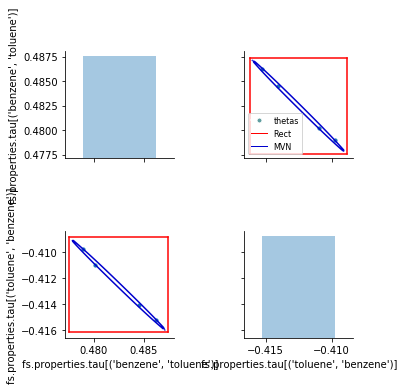

In [13]:
parmest.pairwise_plot(bootstrap_theta, alpha=0.75, distributions=['Rect', 'MVN'])